In [6]:
import pandas as pd
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [7]:
movie_file = Path("../jeff_analysis/final_df.csv")

movie_df = pd.read_csv(movie_file)

movie_df['Director'] = movie_df['Director'].str.replace('Directors:', '')
movie_df.head()

,title,revenue,budget,genres,release_date,Rotten Tomatoes Rating,Metascore,profit,Director,Actors,main_genre_movie,side_genre_movie
0,Inception,825532764,160000000,"Action, Science Fiction, Adventure",7/15/2010,0.87,74,665532764,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",Action,"Adventure, Sci-Fi"
1,Interstellar,701729206,165000000,"Adventure, Drama, Science Fiction",11/5/2014,0.73,74,536729206,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",Adventure,"Drama, Sci-Fi"
2,The Dark Knight,1004558444,185000000,"Drama, Action, Crime, Thriller",7/16/2008,0.94,84,819558444,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Action,"Crime, Drama"
3,Avatar,2923706026,237000000,"Action, Adventure, Fantasy, Science Fiction",12/15/2009,0.82,83,2686706026,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Action,"Adventure, Fantasy"
4,The Avengers,1518815515,220000000,"Science Fiction, Action, Adventure",4/25/2012,0.91,69,1298815515,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...",Action,"Adventure, Sci-Fi"


In [8]:
#Filtering (Cleaning) movie_df

df_unique = movie_df.drop_duplicates(subset='title', keep='first')
filter_criteria = (
    (df_unique['Metascore'].notna()) &
    (df_unique['revenue'].notna()) &
    (df_unique['Metascore'] != 'Rating not found') &
    (df_unique['revenue'] != 'Box Office not found')
    # (df_unique['Total_Gross'] != 'Gross Unknown')
)
clean_movie_df = df_unique[filter_criteria]

### The input cell below groups the data by "Single Director" and "Multiple Directors"

In [9]:
# Create a new column "Director_Type" based on the number of directors
clean_movie_df['Director_Type'] = clean_movie_df['Director'].apply(lambda x: 'Multiple Directors' if ',' in x else 'Single Director')

# Group the DataFrame by the "Director_Type" column
grouped_director_type = clean_movie_df.groupby('Director_Type')

grouped_director_type

### The input cell below splits "Multiple Directors" into individual elements

In [10]:
# Identify rows with multiple directors
multiple_directors_mask = clean_movie_df['Director'].str.contains(',')

# Split multiple directors into individual values and create new rows
multiple_directors_df = clean_movie_df[multiple_directors_mask].copy()
multiple_directors_df['Director'] = multiple_directors_df['Director'].str.split(', ')
multiple_directors_df = multiple_directors_df.explode('Director')

# Combine the original DataFrame with the new rows for multiple directors
updated_movie_df = pd.concat([clean_movie_df[~multiple_directors_mask], multiple_directors_df], ignore_index=True)

In [11]:
updated_movie_df['Director_Type'].value_counts()
#1790

Director_Type
Single Director       1391
Multiple Directors     399
Name: count, dtype: int64

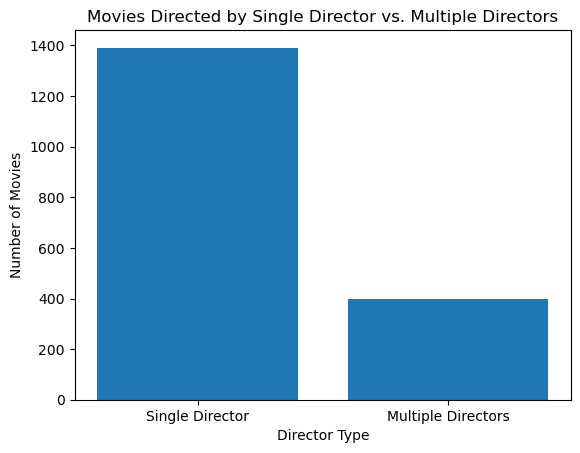

Of the ~6000 Top Movies, 77.71% were directed by an individual director, whereas 22.29% were directed by multiple directors


In [12]:
director_counts = updated_movie_df['Director_Type'].value_counts()
plt.bar(director_counts.index, director_counts.values)
plt.xlabel('Director Type')
plt.ylabel('Number of Movies')
plt.title('Movies Directed by Single Director vs. Multiple Directors')
plt.show();
single_director_percent = 1391 / 1790 * 100
rounded_single = round(single_director_percent, 2)
multiple_director_percent = 399 / 1790 * 100
rounded_multiple = round(multiple_director_percent, 2)
print(f"Of the ~6000 Top Movies, {rounded_single}% were directed by an individual director, whereas {rounded_multiple}% were directed by multiple directors")

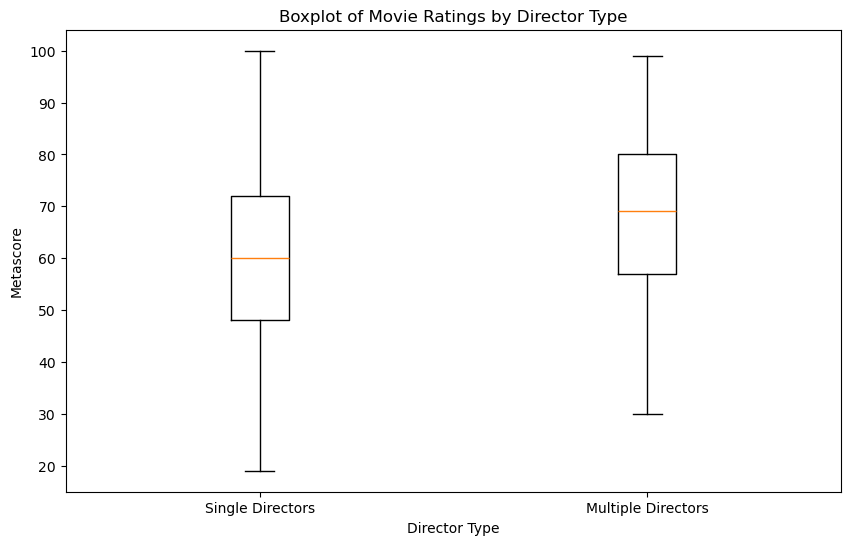

The mean score for movies directed by an individual was 60.54, whereas the mean score for movies directed by multiple directors was 68.79


In [13]:
# Separate the data for Single Directors and Multiple Directors
single_directors_ratings = updated_movie_df[updated_movie_df['Director_Type'] == 'Single Director']['Metascore']
multiple_directors_ratings = updated_movie_df[updated_movie_df['Director_Type'] == 'Multiple Directors']['Metascore']

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([single_directors_ratings, multiple_directors_ratings], labels=['Single Directors', 'Multiple Directors'])
plt.xlabel('Director Type')
plt.ylabel('Metascore')
plt.title('Boxplot of Movie Ratings by Director Type')
plt.show()
# Not sure if this is something noteable, but I'll save it just in case. Mean rating (red line) for Single Directors is 6.75, 
# while the mean rating for multiple directors is 6.84.
single_mean_score = round(single_directors_ratings.mean(),2)
multiple_mean_score = round(multiple_directors_ratings.mean(),2)
print(f"The mean score for movies directed by an individual was {single_mean_score}, whereas the mean score for movies directed by multiple directors was {multiple_mean_score}")

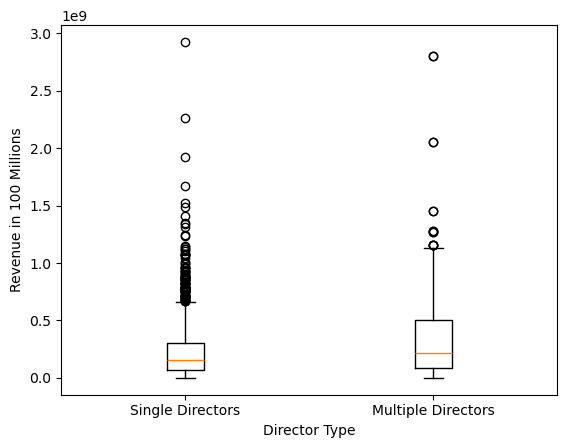

In [14]:
# cleaned_boxoffice = clean_movie_df.loc[(clean_movie_df['revenue'] != "Metascore not found") & (clean_movie_df['Metascore'].notna())]
# cleaned_boxoffice['Metascore'] = cleaned_boxoffice['Metascore'].str.replace('[\$,]', '', regex=True).astype(int)

box_and_directortype = updated_movie_df[['revenue', 'Director_Type']]

single_directors_box = box_and_directortype[box_and_directortype['Director_Type'] == 'Single Director']['revenue']
multiple_directors_box = box_and_directortype[box_and_directortype['Director_Type'] == 'Multiple Directors']['revenue']
plt.boxplot([single_directors_box, multiple_directors_box], labels=['Single Directors', 'Multiple Directors'])
plt.xlabel('Director Type')
plt.ylabel('Revenue in 100 Millions')
plt.show();


In [47]:
# Top Directors dataframe
clean_movie_df['Director']

# Split directors in cells containing multiple directors into separate rows
directors_df = clean_movie_df['Director'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Director')

# Count the occurrences of each director
director_counts = directors_df.value_counts()

# Sort the directors based on the number of movies they have made
most_movies_directors = director_counts.head()


# Display the directors who made the most movies
most_movies_directors_df = most_movies_directors.reset_index()
most_movies_directors_df.columns = ['Director', 'Total Movies Directed']
most_movies_directors_df

,Director,Total Movies Directed
0,Steven Spielberg,22
1,Clint Eastwood,15
2,Tim Burton,14
3,Ridley Scott,13
4,Robert Zemeckis,12


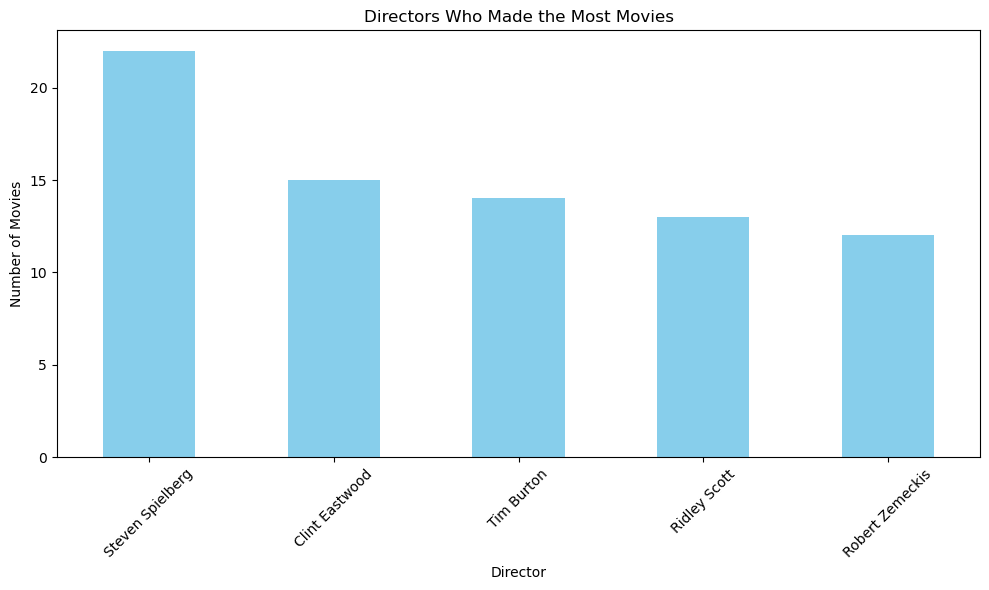

In [44]:

# Plotting the directors who made the most movies as a bar chart
plt.figure(figsize=(10, 6))
most_movies_directors.plot(kind='bar', color='skyblue')
plt.title('Directors Who Made the Most Movies')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.show();


In [48]:
top_directors = ['Steven Spielberg', 'Clint Eastwood', 'Tim Burton', 'Ridley Scott', 'Robert Zemeckis']

top_directors_df = clean_movie_df[clean_movie_df['Director'].str.contains('|'.join(top_directors))].sort_values(by='Director')
top_directors_df_clean = top_directors_df.assign(Director=top_directors_df['Director'].str.split(', ')).explode('Director')
top_directors_df_clean['Director'].tolist()

['Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Clint Eastwood',
 'Don Siegel',
 'Clint Eastwood',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Ridley Scott',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Robert Zemeckis',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven Spielberg',
 'Steven S

C:\Users\jvvil\AppData\Local\Temp\ipykernel_20528\1555642651.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_directors_filtered = top_directors_df_clean[~top_directors_df['Director'].isin(directors_to_remove)]


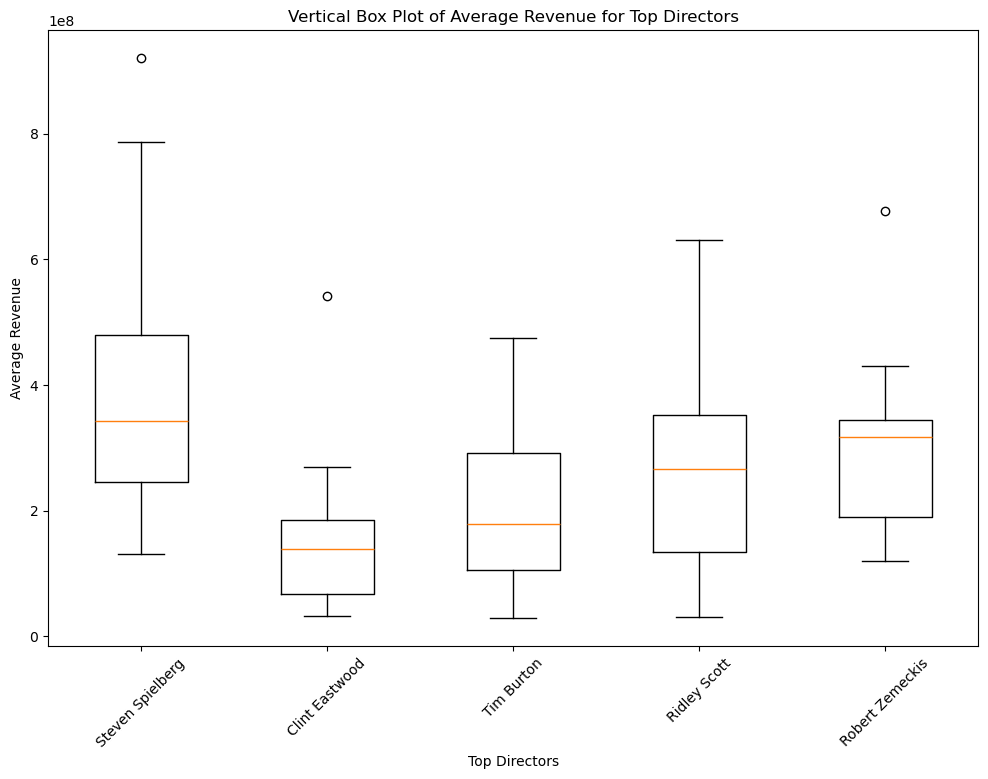

Director: Steven Spielberg, Average Revenue: $333,000,000.00
Director: Clint Eastwood, Average Revenue: $31,794,718.00
Director: Tim Burton, Average Revenue: $245,527,149.00
Director: Ridley Scott, Average Revenue: $630,600,000.00
Director: Robert Zemeckis, Average Revenue: $119,520,023.00


In [54]:
# List of the top 5 directors
top_directors = ['Steven Spielberg', 'Clint Eastwood', 'Tim Burton', 'Ridley Scott', 'Robert Zemeckis']

# Create a new DataFrame with rows that match the top directors
top_directors_df = clean_movie_df[clean_movie_df['Director'].str.contains('|'.join(top_directors))].sort_values(by='Director')

# Display the new DataFrame
top_directors_df_clean = top_directors_df.assign(Director=top_directors_df['Director'].str.split(', ')).explode('Director')

# List of directors to remove
directors_to_remove = ['Don Siegel', 'Mike Johnson']

# Filter out the directors to remove from the DataFrame
top_directors_filtered = top_directors_df_clean[~top_directors_df['Director'].isin(directors_to_remove)]

# Create a vertical box plot for the average revenue data of the top directors
plt.figure(figsize=(12, 8))
plt.boxplot([top_directors_filtered[top_directors_filtered['Director'] == director]['revenue'] for director in top_directors],
            labels=top_directors)
plt.xticks(rotation=45)
plt.xlabel('Top Directors')
plt.ylabel('Average Revenue')
plt.title('Vertical Box Plot of Average Revenue for Top Directors')
plt.show()

for director in top_directors:
    avg_revenue = top_directors_filtered.loc[top_directors_filtered['Director'] == director, 'revenue'].values[0]
    formatted_avg_revenue = "${:,.2f}".format(avg_revenue)
    print(f"Director: {director}, Average Revenue: {formatted_avg_revenue}")

In [55]:
#Transforming Metascore from Object into Float to get summary stats
clean_movie_df['Metascore'].astype(float).describe()

count    1557.000000
mean       61.210662
std        16.300813
min        19.000000
25%        49.000000
50%        61.000000
75%        73.000000
max       100.000000
Name: Metascore, dtype: float64

In [61]:
# List of directors to remove
directors_to_remove = ['Don Siegel', 'Mike Johnson']

# Filter out the directors to remove from the DataFrame
top_directors_filtered = top_directors_df_clean.loc[~top_directors_df_clean['Director'].isin(directors_to_remove)]

top_director_metascore = top_directors_filtered.groupby('Director')['Metascore'].mean()
top_director_metascore

Director
Clint Eastwood      72.750000
Ridley Scott        66.692308
Robert Zemeckis     67.500000
Steven Spielberg    72.909091
Tim Burton          65.857143
Name: Metascore, dtype: float64

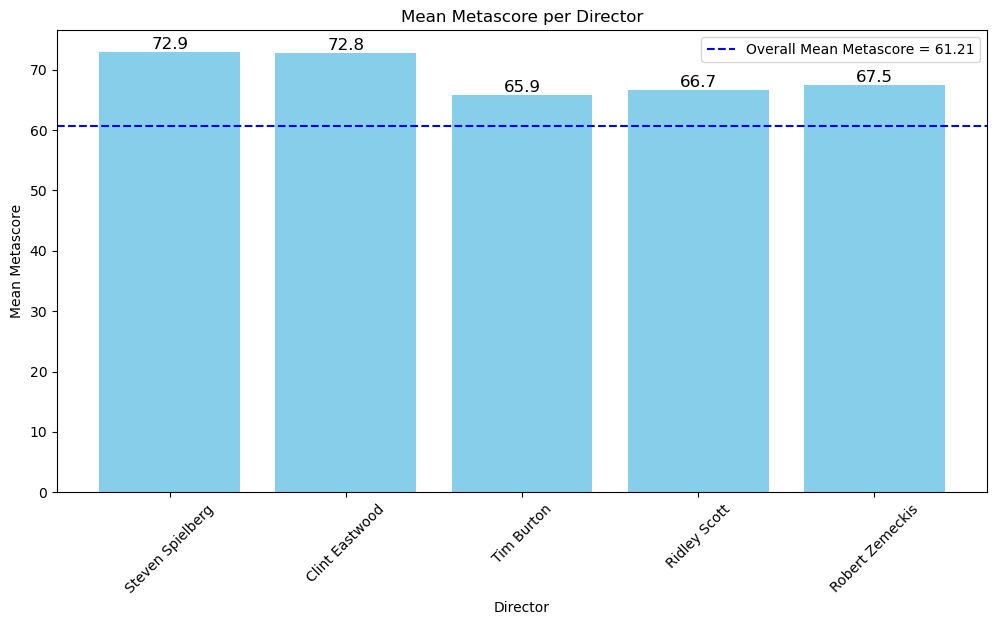

In [62]:
# Data for mean Metascore per director to be used for Bar Graph
top_directors = ['Steven Spielberg', 'Clint Eastwood', 'Tim Burton', 'Ridley Scott', 'Robert Zemeckis']
mean_metascores = [72.91, 72.75, 65.86, 66.69, 67.5]

plt.figure(figsize=(12, 6))
bars = plt.bar(top_directors, mean_metascores, color='skyblue')
plt.xlabel('Director')
plt.ylabel('Mean Metascore')
plt.title('Mean Metascore per Director')
plt.xticks(rotation=45)

# Showing a horizontal line of the mean metascore of all movies in the clean_movie_df
plt.axhline(y=60.6, color='b', linestyle='--', label='Overall Mean Metascore = 61.21')
plt.legend()

# Labelling each Bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom', ha='center', fontsize=12)

plt.show();